## 0.0. Requirements

### 0.1. Imports

In [104]:
import seaborn as sns
from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport

from pyspark.sql import types
from pyspark.sql import SparkSession
from pyspark.sql import functions as pf

### 0.2. Aux Functions

In [105]:
def plot_simple_customer_statistics(df, customerid):
    df_max_gross = df.filter(pf.col("customerid") == customerid)

    df_max_gross.groupBy("customerid").agg(
        pf.min(pf.col("unitprice")).alias("min_product_price"), 
        pf.max(pf.col("unitprice")).alias("max_product_price"),
        pf.sum(pf.col("quantity")).alias("total_itens"),
        pf.count_distinct(pf.col("stockcode")).alias("unique_stockcodes"),
        pf.count_distinct(pf.col("invoiceno")).alias("unique_invoiceno"),
        pf.min(pf.col("invoicedate")).alias("first_purchase"),
        pf.max(pf.col("invoicedate")).alias("last_purchase")
    ).show()

### 0.3. Read Data

In [106]:
base_columns = [
    "InvoiceNo",
    "StockCode",
    "Description",
    "Quantity",
    "InvoiceDate",
    "UnitPrice",
    "CustomerID",
    "Country"
]

data_path = "/home/grc/arep/insiders_clustering/data/Ecommerce.csv"

In [107]:
spark = SparkSession.builder \
        .master("local[4]") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .appName("insiders") \
        .getOrCreate()

In [108]:
df_raw = spark.read.format("csv").option("header", "true").option("inferSchema" , "true").load(data_path)

df_raw = df_raw.select(base_columns)

In [109]:
df_raw.show(5)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|  29-Nov-16|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|  29-Nov-16|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|  29-Nov-16|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|  29-Nov-16|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|  29-Nov-16|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
only showing top 5 rows



## 1.0. Descriptive Statistics

### 1.1. Rename Columns

In [110]:
df1 = df_raw.select([pf.col(k).alias(k.lower().replace(" ", "_").strip()) for k in df_raw.columns])

### 1.2. Change Dtypes

In [111]:
df1.printSchema()

root
 |-- invoiceno: string (nullable = true)
 |-- stockcode: string (nullable = true)
 |-- description: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- invoicedate: string (nullable = true)
 |-- unitprice: double (nullable = true)
 |-- customerid: integer (nullable = true)
 |-- country: string (nullable = true)



In [112]:
df1 = df1.withColumn(
    "invoicedate",
    pf.to_date(pf.unix_timestamp(pf.col("invoicedate"), "d-MMM-yy").cast("timestamp"))
)

### 1.3. Fill Missing Values

In [113]:
df1.select(
    [pf.count(pf.when(pf.isnull(pf.col(k)), 1)).alias(k) for k in df1.columns]
).show(2)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|invoiceno|stockcode|description|quantity|invoicedate|unitprice|customerid|country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [114]:
df1.filter(pf.isnull(pf.col("description"))).show(2)

+---------+---------+-----------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+-----------+--------+-----------+---------+----------+--------------+
|   536414|    22139|       null|      56| 2016-11-29|      0.0|      null|United Kingdom|
|   536545|    21134|       null|       1| 2016-11-29|      0.0|      null|United Kingdom|
+---------+---------+-----------+--------+-----------+---------+----------+--------------+
only showing top 2 rows



In [115]:
df1.filter(pf.isnull(pf.col("customerid"))).show(2)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536414|    22139|                null|      56| 2016-11-29|      0.0|      null|United Kingdom|
|   536544|    21773|DECORATIVE ROSE B...|       1| 2016-11-29|     2.51|      null|United Kingdom|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
only showing top 2 rows



In [116]:
# Remove Description and customer id null :(
df1 = df1.filter(
    pf.col("customerid").isNotNull() &
    pf.col("description").isNotNull()
)

### 1.4. Normalization Rows

In [117]:
for col in [k.name for k in df1.schema if k.dataType.typeName() in ['string']]:
    df1 = df1.withColumn(
        col,
        pf.regexp_replace(pf.lower(pf.trim(pf.col(col))), " ", "_")
    )

### 1.5. Descriptive Statistics

#### 1.5.1. Numeric Attributes

In [118]:
df_numeric = df1.select([k.name for k in df1.schema if k.dataType.typeName() in ['double', 'integer']])

In [119]:
df_c_distinct = df_numeric.select([pf.count_distinct(pf.col(k)).alias(k) for k in df_numeric.columns])
df_c_distinct = df_c_distinct.withColumn("summary", pf.lit("count_distinct"))
df_c_distinct = df_c_distinct.select(["summary"] + df_numeric.columns)

df_median = df_numeric.select([pf.median(pf.col(k)).alias(k) for k in  df_numeric.columns])
df_median = df_median.withColumn("summary", pf.lit("median"))
df_median = df_median.select(["summary"] + df_numeric.columns)

df_skewness = df_numeric.select([pf.skewness(pf.col(k)).alias(k) for k in df_numeric.columns])
df_skewness = df_skewness.withColumn("summary", pf.lit("skewness"))
df_skewness = df_skewness.select(["summary"] + df_numeric.columns)

df_kurtosis = df_numeric.select([pf.kurtosis(pf.col(k)).alias(k) for k in df_numeric.columns])
df_kurtosis = df_kurtosis.withColumn("summary", pf.lit("kurtosis"))
df_kurtosis = df_kurtosis.select(["summary"] + df_numeric.columns)

df_mode = df_numeric.select([pf.mode(pf.col(k)).alias(k) for k in df_numeric.columns])
df_mode = df_mode.withColumn("summary", pf.lit("mode"))
df_mode = df_mode.select(["summary"] + df_numeric.columns)

In [120]:
df_c_distinct.union(df_numeric.describe()).union(df_median).union(df_skewness).union(df_kurtosis).union(df_mode).show()

+--------------+-------------------+------------------+--------------------+
|       summary|           quantity|         unitprice|          customerid|
+--------------+-------------------+------------------+--------------------+
|count_distinct|                436|               620|                4372|
|         count|             406829|            406829|              406829|
|          mean|  12.06130339774205| 3.460471018537621|  15287.690570239585|
|        stddev| 248.69337001882548| 69.31516172321396|   1713.600303321593|
|           min|             -80995|               0.0|               12346|
|           max|              80995|           38970.0|               18287|
|        median|                5.0|              1.95|             15152.0|
|      skewness|0.18266199524826318|  452.217351341756|0.029834880048379368|
|      kurtosis|  94316.40448314806|246921.50823746304| -1.1799826182500506|
|          mode|                  1|              1.25|               17841|

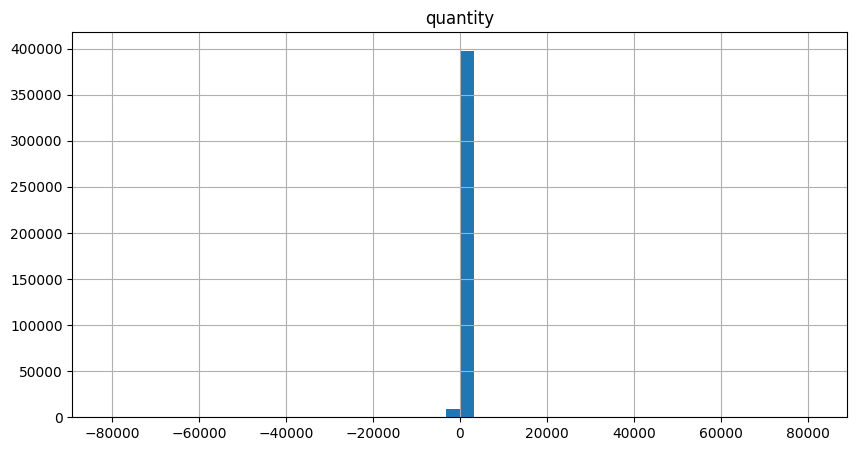

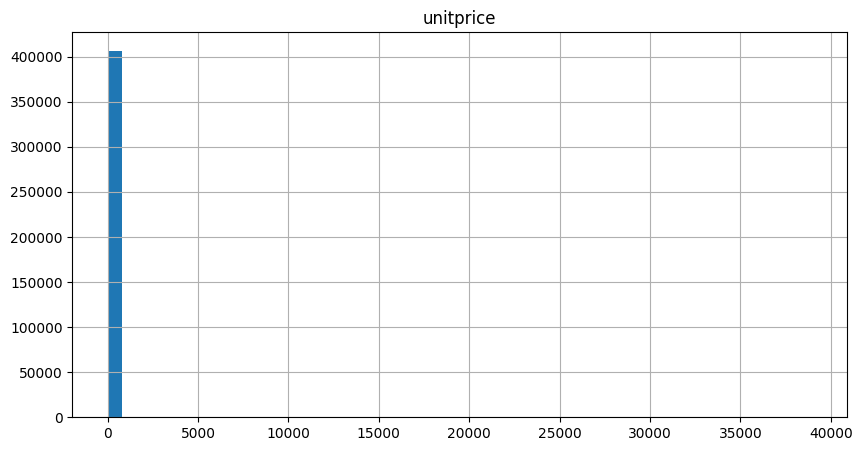

In [121]:
for k in ['quantity', 'unitprice']:
    df_numeric.select(k).toPandas().hist(figsize=(10,5), bins=50);

#### 1.5.2. Categorical Attributes

In [122]:
df_categorical = df1.select([k.name for k in df1.schema if k.dataType.typeName() in ['string']])

In [123]:
df_c_distinct = df_categorical.select([pf.count_distinct(pf.col(k)).alias(k) for k in df_categorical.columns])
df_c_distinct = df_c_distinct.withColumn("summary", pf.lit("count_distinct"))
df_c_distinct = df_c_distinct.select(["summary"] + df_categorical.columns)

df_c_distinct.union(df_categorical.describe()).show()

+--------------+------------------+------------------+--------------------+---------+
|       summary|         invoiceno|         stockcode|         description|  country|
+--------------+------------------+------------------+--------------------+---------+
|count_distinct|             22190|              3684|                3885|       37|
|         count|            406829|            406829|              406829|   406829|
|          mean| 560617.1266447864|27430.341352504624|                null|     null|
|        stddev|13106.167694744545| 16403.57045262611|                null|     null|
|           min|            536365|             10002|"assorted_flower_...|australia|
|           max|           c581569|              post|zinc_wire_sweethe...|      usa|
+--------------+------------------+------------------+--------------------+---------+



##### 1.5.2.1. Stock Code

In [124]:
df_categorical.select(
    pf.regexp_replace(
        pf.regexp_replace(pf.col("stockcode"), "[0-9]+[a-z]", ""),
        "[0-9]+", ""
    ).alias("stockcode")
).distinct().show()

+------------+
|   stockcode|
+------------+
|           l|
|           m|
|bank_charges|
|           d|
|           c|
|            |
|        post|
|        pads|
|         dot|
|        cruk|
+------------+



In [125]:
df_filter = df_categorical.select(
    pf.regexp_replace(pf.col("stockcode"), "[0-9]+", "")
).distinct()

In [126]:
df_filter.filter(
    pf.col("stockcode").contains("l")
).distinct().show()

+--------------------------------------+
|regexp_replace(stockcode, [0-9]+, , 1)|
+--------------------------------------+
|                                    bl|
|                                     l|
+--------------------------------------+



In [127]:
filter_stock_codes = df_categorical.select(
    pf.regexp_replace(
        pf.regexp_replace(pf.col("stockcode"), "[0-9]+[a-z]", ""),
        "[0-9]+", ""
    ).alias("stockcode")
).distinct().collect()

filter_stock_codes = [k.asDict()["stockcode"] for k in filter_stock_codes]

##### 1.5.2.2. Invoice No

In [128]:
df_categorical.select(
    pf.regexp_replace(
        pf.regexp_replace(pf.col("invoiceno"), "[0-9]+[a-z]", ""),
        "[0-9]+", ""
    ).alias("invoiceno")
).distinct().show()

+---------+
|invoiceno|
+---------+
|        c|
|         |
+---------+



In [129]:
df1.filter(
    pf.col("invoiceno").contains("c")
).show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|  c536379|        d|            discount|      -1| 2016-11-29|     27.5|     14527|united_kingdom|
|  c536383|   35004c|set_of_3_coloured...|      -1| 2016-11-29|     4.65|     15311|united_kingdom|
|  c536391|    22556|plasters_in_tin_c...|     -12| 2016-11-29|     1.65|     17548|united_kingdom|
|  c536391|    21984|pack_of_12_pink_p...|     -24| 2016-11-29|     0.29|     17548|united_kingdom|
|  c536391|    21983|pack_of_12_blue_p...|     -24| 2016-11-29|     0.29|     17548|united_kingdom|
|  c536391|    21980|pack_of_12_red_re...|     -24| 2016-11-29|     0.29|     17548|united_kingdom|
|  c536391|    21484|chick_grey_hot_wa...|     -12| 2016-11-29|     3.45|     17548|united_kingdom|


In [130]:
df1.select(["invoiceno", "quantity"]).filter(
    pf.col("invoiceno").contains("c")
).distinct().show()

+---------+--------+
|invoiceno|quantity|
+---------+--------+
|  c538833|      -2|
|  c539644|      -1|
|  c540270|      -1|
|  c542366|      -2|
|  c542424|      -5|
|  c545436|      -1|
|  c538059|      -6|
|  c538350|      -4|
|  c539956|     -15|
|  c542348|      -1|
|  c542805|      -1|
|  c543757|      -1|
|  c544420|      -2|
|  c545769|     -18|
|  c546302|      -1|
|  c546901|      -2|
|  c548463|     -46|
|  c548972|      -4|
|  c537853|      -1|
|  c539289|      -3|
+---------+--------+
only showing top 20 rows



In [131]:
df1.filter(
    (pf.col("invoiceno").contains("c")) &
    (pf.col("quantity") >= 0)
).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|invoiceno|stockcode|description|quantity|invoicedate|unitprice|customerid|country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
+---------+---------+-----------+--------+-----------+---------+----------+-------+



##### 1.5.2.3. Country

In [132]:
df1.select("country").distinct().show(10)

+--------------+
|       country|
+--------------+
|       finland|
|     australia|
|        greece|
|      portugal|
|        israel|
|        poland|
|       austria|
|czech_republic|
|       lebanon|
|         japan|
+--------------+
only showing top 10 rows



In [133]:
df1.groupBy("country").count().orderBy("count").show()

+--------------------+-----+
|             country|count|
+--------------------+-----+
|        saudi_arabia|   10|
|             bahrain|   17|
|      czech_republic|   30|
|              brazil|   32|
|           lithuania|   35|
|             lebanon|   45|
|                 rsa|   58|
|  european_community|   61|
|united_arab_emirates|   68|
|               malta|  127|
|              greece|  146|
|              canada|  151|
|             iceland|  182|
|           singapore|  229|
|         unspecified|  244|
|              israel|  250|
|                 usa|  291|
|              poland|  341|
|               japan|  358|
|             denmark|  389|
+--------------------+-----+
only showing top 20 rows



## 2.0. Business Data Filtering

### 2.1. Filtering Rows and Columns

In [134]:
df2 = df1.select(
    "invoiceno",
    "stockcode",
    "quantity",
    "invoicedate",
    "unitprice",
    "customerid",
    "country"
).filter(
    (pf.col("unitprice") > 0.04) &
    (~pf.col("stockcode").isin(filter_stock_codes)) &
    (~pf.col("country").isin(["european_community", "unspecified"])) & 
    (~pf.col("customerid").isin(
        [16446, 12346, 15749, 15098, 15749]
    ))
)

In [135]:
df2_returns = df2.filter(pf.col("quantity") < 0)
df2_purchases = df2.filter(pf.col("quantity") > 0)

## 3.0. Feature Engineering

In [147]:
df_ref = df2.select("customerid").distinct()

### 3.1. Gross Revenue

Unit price * quantity

In [148]:
df2_purchases = df2_purchases.withColumn(
    "gross_revenue",
    pf.round(pf.col("quantity") * pf.col("unitprice"), 3)
)

df_gross_revenue = df2_purchases.groupBy("customerid").agg(pf.sum(pf.col("gross_revenue")).alias("gross_revenue"))

df_ref = df_ref.join(df_gross_revenue, on="customerid", how="left")

### 3.2. Recency

Quantity of days util last purchase

In [149]:
df_recency = df2_purchases.groupBy("customerid").agg(pf.max(pf.col("invoicedate")).alias("last_purchase"))

df_recency = df_recency.withColumn(
    "max_invoicedate",
    pf.lit(df2_purchases.select(pf.max(pf.col("invoicedate"))).collect()[0][0])
)

df_recency = df_recency.withColumn(
    "recency_days",
    pf.datediff(pf.col("max_invoicedate"), pf.col("last_purchase"))
)

df_ref = df_ref.join(df_recency.select("customerid", "recency_days"), on="customerid", how="left")

### 3.3. Quantity of Stock Code Purchase

Quantity of stock codes (products) purchased.

In [150]:
df_qtd_products = df2_purchases.groupBy("customerid").agg(pf.count_distinct(pf.col("stockcode")).alias("qtde_products"))

df_ref = df_ref.join(df_qtd_products, on="customerid", how="left")

### 3.4. Sum of Item Quantity Purchase

In [151]:
df_qtd_items = df2_purchases.groupBy("customerid").agg(pf.sum(pf.col("quantity")).alias("qtde_total_items"))

df_ref = df_ref.join(df_qtd_items, on="customerid", how="left")

### 3.5. Gross Revenue By Quantity Products

how much gross revenue is generated for total unit of product quantity sold

In [152]:
df_ref = df_ref.withColumn(
    "gross_by_quantity",
    pf.col("gross_revenue") / pf.col("qtde_total_items")
)

### 3.6. Frequency

Quantity Products / Customer Lifetime interval days

In [153]:
df_distinct = df2_purchases.select("customerid", "invoicedate", "invoiceno").distinct()

df_distinct = df_distinct.groupBy("customerid").agg(
    pf.max(pf.col("invoicedate")).alias("_max"),
    pf.min(pf.col("invoicedate")).alias("_min"),
    pf.count(pf.col("invoiceno")).alias("_buy")
)

df_distinct = df_distinct.withColumn(
    "_diff",
    pf.datediff(pf.col("_max"), pf.col("_min")) + 1
)

df_distinct = df_distinct.withColumn(
    "frequency",
    pf.col("_buy") / pf.col("_diff")
).select(
    pf.col("customerid"),
    pf.col("frequency")
)

df_ref = df_ref.join(df_distinct, on="customerid", how="left")

### 3.7. Qtd Returns

In [154]:
df_returns = df2_returns.groupBy("customerid").agg(pf.sum("quantity").alias("qtde_returns"))

df_returns = df_returns.withColumn(
    "qtde_returns",
    pf.col("qtde_returns") * -1
)

df_ref = df_ref.join(df_returns, on="customerid", how="left")

### 3.8. Quantity of Invoices

In [155]:
df_invoices = df2_purchases.groupBy("customerid").agg(pf.count_distinct(pf.col("invoiceno")).alias("qtde_invoices"))

df_ref = df_ref.join(df_invoices, on="customerid", how="left")

### 3.9. Check Null Values

In [156]:
df_ref.show()

+----------+------------------+------------+-------------+----------------+------------------+--------------------+------------+-------------+
|customerid|     gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|           frequency|qtde_returns|qtde_invoices|
+----------+------------------+------------+-------------+----------------+------------------+--------------------+------------+-------------+
|     17420| 598.8299999999999|          50|           28|             265|2.2597358490566033|0.009259259259259259|        null|            3|
|     16861|            173.76|          59|            6|             140| 1.241142857142857|                0.02|           6|            2|
|     16503|1431.9299999999998|         106|           71|             569|2.5165729349736377| 0.01568627450980392|           2|            4|
|     15727| 5178.959999999998|          16|          213|            3065|1.6897096247960843|0.020348837209302327|        null|            7|

In [157]:
df_ref.select(
    [pf.count(pf.when(pf.isnull(pf.col(k)), 1)).alias(k) for k in df_ref.columns]
).show()

+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|customerid|gross_revenue|recency_days|qtde_products|qtde_total_items|gross_by_quantity|frequency|qtde_returns|qtde_invoices|
+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|         0|           28|          28|           28|              28|               28|       28|        2825|           28|
+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+



In [158]:
# If returns is none, the customer never returned nothing
df_ref = df_ref.na.fill(value=0, subset=["qtde_returns"])

In [159]:
df_ref.filter(pf.isnull(pf.col("gross_revenue"))).show()

+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|customerid|gross_revenue|recency_days|qtde_products|qtde_total_items|gross_by_quantity|frequency|qtde_returns|qtde_invoices|
+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|     12943|         null|        null|         null|            null|             null|     null|           1|         null|
|     16138|         null|        null|         null|            null|             null|     null|           1|         null|
|     13958|         null|        null|         null|            null|             null|     null|          23|         null|
|     17547|         null|        null|         null|            null|             null|     null|           4|         null|
|     15638|         null|        null|         null|            null|             null|     null|          52|       

In [160]:
df_ref = df_ref.filter((~pf.isnull(pf.col("gross_revenue"))))

In [161]:
df_ref.select(
    [pf.count(pf.when(pf.isnull(pf.col(k)), 1)).alias(k) for k in df_ref.columns]
).show()

+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|customerid|gross_revenue|recency_days|qtde_products|qtde_total_items|gross_by_quantity|frequency|qtde_returns|qtde_invoices|
+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|         0|            0|           0|            0|               0|                0|        0|           0|            0|
+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+



## 4.0. EDA Feature Behavior for Clustering

In [162]:
df4 = df_ref.select([pf.col(k) for k in df_ref.columns])

### 4.1. Univariate Analysis

In [163]:
df4.describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+-------------------+--------------------+------------------+-----------------+
|summary|        customerid|     gross_revenue|      recency_days|    qtde_products|  qtde_total_items|  gross_by_quantity|           frequency|      qtde_returns|    qtde_invoices|
+-------+------------------+------------------+------------------+-----------------+------------------+-------------------+--------------------+------------------+-----------------+
|  count|              4325|              4325|              4325|             4325|              4325|               4325|                4325|              4325|             4325|
|   mean|15300.929248554914|1949.9365156069393| 92.09387283236994|61.48184971098266|1149.8839306358382| 2.2349171280083304|  0.4042442400569476|21.850173410404626|4.250635838150289|
| stddev|1721.9331026971438| 8445.945448654618|100.16102194111322|85.35167201157616| 4761.

In [164]:
profile = ProfileReport(df4.toPandas())
profile.to_file("output_v2.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 117.78it/s]


#### 4.1.1. Gross Revenue

In [173]:
df_95_percent = df4.filter(pf.col("gross_revenue") > 5734.5635)

In [174]:
df_95_percent.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+
|summary|        customerid|     gross_revenue|      recency_days|     qtde_products|  qtde_total_items| gross_by_quantity|           frequency|      qtde_returns|     qtde_invoices|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+
|  count|               214|               214|               214|               214|               214|               214|                 214|               214|               214|
|   mean|14887.275700934579|19120.744158878515|18.200934579439252|207.22429906542055|10777.570093457944|2.0223739829661596| 0.10974740937469499|242.51869158878506| 22.72429906542056|
| stddev|1792.7062930691134| 33346.78311119376|31.195458304707934|237.76187671094794|

##### 4.1.1.1. Max Quantity Itens 

In [184]:
df_95_percent.filter(pf.col("qtde_total_items") == 196844).show()

+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|customerid|    gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|         frequency|qtde_returns|qtde_invoices|
+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|     14646|279138.0199999998|           1|          699|          196844|1.4180672004226687|0.2033898305084746|         288|           72|
+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+



##### 4.1.1.2. Recency Days Top Gross Revenue

In [192]:
df_95_percent.select(pf.max(pf.col("qtde_total_items"))).show()

# On previous analisys on another notebook, theses clients now filter
df_95_percent.select("qtde_total_items").distinct().sort(pf.col("qtde_total_items").desc()).show(20)

+---------------------+
|max(qtde_total_items)|
+---------------------+
|               196844|
+---------------------+



+----------------+
|qtde_total_items|
+----------------+
|          196844|
|           79963|
|           77373|
|           69993|
|           64549|
|           64124|
|           62812|
|           58243|
|           57785|
|           50255|
|           40207|
|           38194|
|           33704|
|           32744|
|           32184|
|           31070|
|           30450|
|           29672|
|           28920|
|           28004|
+----------------+
only showing top 20 rows



##### 4.1.1.3. Recency Days Top 1 Gross Revenue

In [187]:
df_95_percent.filter(pf.col("qtde_total_items") == 79963).show()

df1.filter(pf.col("customerid") == 16532).show(5)

+----------+------------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|customerid|     gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|         frequency|qtde_returns|qtde_invoices|
+----------+------------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|     14911|140438.72000000015|           1|         1785|           79963|1.7562962870327545|0.5335120643431636|        3332|          199|
+----------+------------------+------------+-------------+----------------+------------------+------------------+------------+-------------+



In [188]:
plot_simple_customer_statistics(df2, 14911)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     14911|             0.06|            165.0|      76631|             1791|             243|    2016-11-29|   2017-12-06|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+



##### 4.1.1.4. Recency Days Top 2 Gross Revenue

In [190]:
df_95_percent.filter(pf.col("qtde_total_items") == 77373).show()

df1.filter(pf.col("customerid") == 12415).show(5)

+----------+-------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+
|customerid|gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|          frequency|qtde_returns|qtde_invoices|
+----------+-------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+
|     12415|    124564.53|          24|          443|           77373|1.6099224535690744|0.06369426751592357|         427|           20|
+----------+-------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+

+---------+---------+--------------------+--------+-----------+---------+----------+---------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|  country|
+---------+---------+--------------------+--------+-----------+---------+----------+---------+
|   540267|    22078|ribbon_r

In [191]:
plot_simple_customer_statistics(df2, 12415)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     12415|             0.19|            14.95|      76946|              443|              24|    2017-01-04|   2017-11-13|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+



##### 4.1.1.5. Recency Days Top 3 Gross Revenue

In [194]:
df_95_percent.filter(pf.col("qtde_total_items") == 69993).show()

df1.filter(pf.col("customerid") == 17450).show(5)

+----------+-----------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+
|customerid|    gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|          frequency|qtde_returns|qtde_invoices|
+----------+-----------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+
|     17450|194550.7899999999|           8|          124|           69993|2.7795749574957482|0.12777777777777777|         952|           46|
+----------+-----------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+----------

In [195]:
plot_simple_customer_statistics(df2, 17450)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     17450|             0.72|            12.98|      69041|              124|              49|    2016-12-05|   2017-11-29|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+



##### 4.1.1.6. Max Frequency 

In [196]:
df_95_percent.filter(pf.col("frequency") >= 3.).show()

+----------+-----------------+------------+-------------+----------------+------------------+---------+------------+-------------+
|customerid|    gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|frequency|qtde_returns|qtde_invoices|
+----------+-----------------+------------+-------------+----------------+------------------+---------+------------+-------------+
|     16000|          12393.7|           2|            9|            5110|2.4253816046966734|      3.0|           0|            3|
|     18139|8438.339999999997|          17|           35|            5557|1.5185063883390313|      3.0|           0|            6|
+----------+-----------------+------------+-------------+----------------+------------------+---------+------------+-------------+



In [204]:
df1.filter(pf.col("customerid") == 16000).show(10)

df1.filter(pf.col("customerid") == 18139).show(50)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   581105|    85152|hand_over_the_cho...|     620| 2017-12-05|     1.92|     16000|united_kingdom|
|   581105|    22457|natural_slate_hea...|     620| 2017-12-05|     2.55|     16000|united_kingdom|
|   581105|    22727|alarm_clock_bakel...|     620| 2017-12-05|     2.99|     16000|united_kingdom|
|   581105|    23497|classic_chrome_bi...|     620| 2017-12-05|     1.38|     16000|united_kingdom|
|   581105|    23498|classic_bicycle_c...|     620| 2017-12-05|     1.38|     16000|united_kingdom|
|   581105|    22961|jam_making_set_pr...|     620| 2017-12-05|     1.38|     16000|united_kingdom|
|   581105|    23552|bicycle_puncture_...|     620| 2017-12-05|     1.86|     16000|united_kingdom|


In [200]:
plot_simple_customer_statistics(df2, 16000)

plot_simple_customer_statistics(df2, 18139)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     16000|             1.38|            13.35|       5110|                9|               3|    2017-12-05|   2017-12-05|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+

##### 4.1.1.7. Max & Min Invoices

In [208]:
df_95_percent.filter(pf.col("qtde_invoices") == 1).show()

df_95_percent.filter(pf.col("qtde_invoices") >= 200).show()

+----------+-----------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|customerid|    gross_revenue|recency_days|qtde_products|qtde_total_items|gross_by_quantity|frequency|qtde_returns|qtde_invoices|
+----------+-----------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|     12590|9341.260000000004|         211|           67|            4282|2.181517982251285|      1.0|           4|            1|
|     12357|6207.669999999996|          33|          131|            2708|2.292344903988182|      1.0|           0|            1|
+----------+-----------------+------------+-------------+----------------+-----------------+---------+------------+-------------+



+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|customerid|    gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|         frequency|qtde_returns|qtde_invoices|
+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|     12748|32305.31999999994|           0|         1765|           25211|1.2813978025465051|0.5508021390374331|        1535|          206|
+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+



In [211]:
df1.filter(pf.col("customerid") == 12590).show()

+---------+---------+--------------------+--------+-----------+---------+----------+-------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|country|
+---------+---------+--------------------+--------+-----------+---------+----------+-------+
|   552978|   85014b|red_retrospot_umb...|      48| 2017-05-10|     4.95|     12590|germany|
|   552978|   85014a|black/blue_polkad...|      48| 2017-05-10|     4.95|     12590|germany|
|   552978|    22354|retrospot_padded_...|      60| 2017-05-10|     3.39|     12590|germany|
|   552978|    22558|clothes_pegs_retr...|      96| 2017-05-10|     1.25|     12590|germany|
|   552978|    22329|round_container_s...|      48| 2017-05-10|     1.45|     12590|germany|
|   552978|    22352|lunch_box_with_cu...|      60| 2017-05-10|      2.1|     12590|germany|
|   552978|    22195|large_heart_measu...|      24| 2017-05-10|     1.65|     12590|germany|
|   552978|    21035|set/2_red_retrosp...|     100| 2017-05-10|     2.

In [209]:
plot_simple_customer_statistics(df2, 12590)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     12590|             0.65|             7.65|       4278|               67|               2|    2017-05-10|   2017-05-31|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+



##### 4.1.1.8. Max Qtde Returns

In [217]:
df_95_percent.sort(pf.col("qtde_returns").desc()).show()

+----------+------------------+------------+-------------+----------------+------------------+--------------------+------------+-------------+
|customerid|     gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|           frequency|qtde_returns|qtde_invoices|
+----------+------------------+------------+-------------+----------------+------------------+--------------------+------------+-------------+
|     16029|          72882.09|          38|           43|           40207|1.8126716740866018| 0.18452380952380953|        8004|           62|
|     12931| 42055.96000000001|          21|           28|           28004|1.5017840308527355| 0.04451038575667656|        4427|           15|
|     14607|           15021.5|          15|           37|           10734|1.3994317123160052|0.048582995951417005|        3768|           12|
|     14911|140438.72000000015|           1|         1785|           79963|1.7562962870327545|  0.5335120643431636|        3332|          199|

In [223]:
df1.filter(
    (pf.col("customerid") == 16029) & 
    (pf.col("quantity") < 0)
).sort(pf.col("quantity").asc()).show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|  c570556|    20971|pink_blue_felt_cr...|   -1296| 2017-10-09|     1.06|     16029|united_kingdom|
|  c570556|    20971|pink_blue_felt_cr...|   -1296| 2017-10-09|     1.06|     16029|united_kingdom|
|  c570556|    22147|feltcraft_butterf...|    -840| 2017-10-09|     1.25|     16029|united_kingdom|
|  c570556|    22273|feltcraft_doll_molly|    -720| 2017-10-09|      2.3|     16029|united_kingdom|
|  c570556|    22273|feltcraft_doll_molly|    -720| 2017-10-09|     2.55|     16029|united_kingdom|
|  c570556|    22149|feltcraft_6_flowe...|    -600| 2017-10-09|     1.85|     16029|united_kingdom|
|  c570552|   85099b|jumbo_bag_red_ret...|    -300| 2017-10-09|     1.74|     16029|united_kingdom|


In [218]:
plot_simple_customer_statistics(df2, 16029)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     16029|             0.94|             8.49|      32203|               43|              66|    2016-11-29|   2017-10-30|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+



In [225]:
df1.filter(
    (pf.col("customerid") == 17949) & 
    (pf.col("quantity") < 0)
).sort(pf.col("quantity").asc()).show()

plot_simple_customer_statistics(df2, 17949)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|  c563577|    21877| home_sweet_home_mug|    -828| 2017-08-15|     1.06|     17949|united_kingdom|
|  c563577|    21069|vintage_billboard...|    -701| 2017-08-15|     1.06|     17949|united_kingdom|
|  c558553|    23170|regency_tea_plate...|    -576| 2017-06-28|     1.45|     17949|united_kingdom|
|  c563577|    21871| save_the_planet_mug|    -576| 2017-08-15|     1.06|     17949|united_kingdom|
|  c564081|    22423|regency_cakestand...|    -150| 2017-08-20|    10.95|     17949|united_kingdom|
|  c554127|        m|              manual|     -96| 2017-05-21|      5.0|     17949|united_kingdom|
|  c580171|    23108|set_of_10_led_dol...|     -24| 2017-11-30|     3.39|     17949|united_kingdom|
